In [1]:
import scipy
import random
import portpy.photon as pp
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
import cvxpy as cp
from scipy.linalg import LinAlgError
import matplotlib.pyplot as plt

In [2]:
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

A_full = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.4.1                                    
(CVXPY) Jan 28 02:47:26 PM: Your problem has 1946 variables, 14 constraints, and 0 parameters.
(CVXPY) Jan 28 02:47:26 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jan 28 02:47:26 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jan 28 02:47:26 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Jan 28 02:47:26 PM: Your problem is compiled with the CPP canonicalization backend.
----------------------------------------

In [3]:
start_time = time.time()

def importance_sampling(A, c):
    d, n = A.shape
    B = np.zeros((d, c))

    for i in range(n):
        # محاسبه احتمال p_i
        p_i = calculate_probability(A[:, i])

        for j in range(c):
            # نمونه‌برداری با احتمال p_i و افزودن به B_(:.j)
            sample = np.random.choice(d, p=p_i)
            B[:, j] += A[:, i] / p_i[sample]

    # مقیاس بندی مجدد
    B /= c

    return B

def calculate_probability(row):
    
    # محاسبه احتمال p_i بر اساس مقدارهای ردیف A_(:.i)
    return row / np.sum(row)
 
c = 542
A = A_full

result = importance_sampling(A, c)
print(result)

end_time = time.time()
total_execution_time = end_time - start_time
print(f"زمان ساخت ماتریس : {total_execution_time} ثانیه")

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
زمان ساخت ماتریس : 242.68908977508545 ثانیه


In [4]:
B = result.T
A = A_full
d = dose_full_1d
print(f'B = {B.shape}\nA = {A.shape}\nd = {d.shape}')

B = (542, 60183)
A = (60183, 542)
d = (60183,)


In [5]:
start_time = time.time()

sol_ls_B = scipy.sparse.linalg.lsqr(B @ A, B @ d )
    
end_time = time.time()
total_execution_time = end_time - start_time
print(f"زمان حل کمترین مربعات{total_execution_time} ثانیه")



زمان حل کمترین مربعات0.4387798309326172 ثانیه


In [6]:
x_sampling = sol_ls_B[0]
cost = sum_squares(B @ A @ x_sampling - B @ d)
prob = Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

198978324.31064004

<br><center> ***Minimize*** $\lVert SAx - Sp\rVert_{2}^2$

  

In [8]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_full = opt.solve(solver='MOSEK', verbose=False)

x_full = sol_full['optimal_intensity'] * plan_full.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


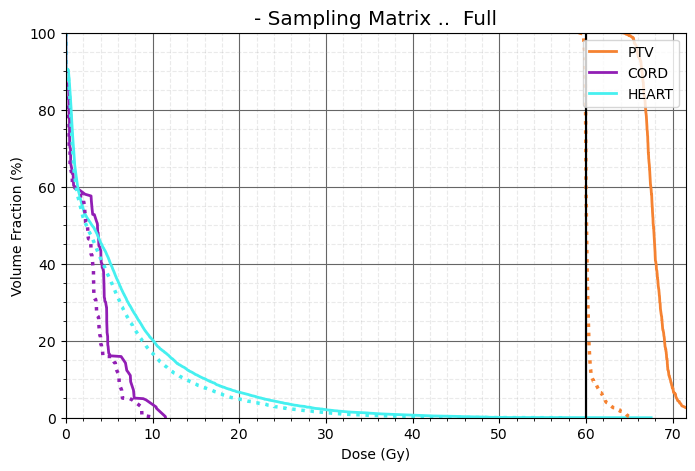

Done!


In [9]:
# DVH Plot
dose_full = plan_full.inf_matrix.A @ x_full
dose_sampling = plan_full.inf_matrix.A @ x_sampling 



fig, ax = plt.subplots(figsize=(8, 5))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d= dose_sampling, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_full, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- Sampling Matrix ...  Full')
plt.show()
print('Done!')

In [10]:
# نوع داده
print("Data Type:", dose_sampling.dtype)

# ابعاد
print("Shape:", dose_sampling.shape)

# تعداد کل عناصر
print("Size:", dose_sampling.size)


Data Type: float64
Shape: (60183,)
Size: 60183


In [11]:
import pandas as pd

# تبدیل numpy.ndarray به DataFrame
dose_sampling_df = pd.DataFrame(dose_sampling)

# استفاده از متد describe روی DataFrame
description = dose_sampling_df.describe()

# نمایش توضیحات
print(description)


                  0
count  60183.000000
mean       6.518793
std       12.206109
min        0.000000
25%        0.343048
50%        1.353335
75%        6.466537
max       73.870515


In [ ]:
nonzero_count = np.count_nonzero(A_full)
print("تعداد مقادیر غیر صفر ماتریس کامل: ", nonzero_count)
num_non_zero = np.count_nonzero(B @ A)
print("تعداد عناصر غیر صفر در ماتریس SA :", num_non_zero)

In [ ]:
##  بررسی  پراکندگی ماتریس

is_sparse = sparse.issparse(result)
is_sparse

In [ ]:
x_sampling = sol_ls_B[0]
print(f'x :\t {x_sampling[0:6]}')

In [12]:
sol_ls_A_full = scipy.sparse.linalg.lsqr(A_full, dose_sparse_1d)
x_A_full = sol_ls_A_full[0]

relative_error = np.linalg.norm(x_A_full - x_sampling) / np.linalg.norm(x_A_full)
print("خطای نسبی بین دو بردار:", relative_error)


خطای نسبی بین دو بردار: 0.16286100848674087


In [15]:
x_A_full= sol_ls_A_full[0]
print(f'x_A_full :\t {x_A_full[0:6]}')

cost = cp.sum_squares((A @ x_A_full  - A @ x_sampling  )/ cp.norm(A @ x_A_full))
prob = cp.Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

x_A_full :	 [ 3.6748923  -1.87874125 -1.95530011 -2.4399406  12.06883105  5.92361035]


0.029430472233158783

In [17]:
import cvxpy as cp

x_A_full = sol_ls_A_full[0]
print(f'x_A_full :\t {x_A_full[0:6]}')

# تغییر تابع هدف به نرم فروبنیوس
cost = cp.norm(A @ x_A_full - A @ x_sampling, "fro")/ cp.norm(A @ x_A_full, "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


x_A_full :	 [ 3.67488292 -1.8787623  -1.95529727 -2.43993656 12.0689664   5.92366068]


0.1715874574131074

In [54]:
#  تعداد عناصر غیر صفر
num_non_zero_elements_dense = np.count_nonzero(B)/32619186
print("تعداد عناصر غیر صفر در ماتریس B:", num_non_zero_elements_dense)

num_non_zero_elements_dense = np.count_nonzero(B @ A)/293764
print("تعداد عناصر غیر صفر در ماتریس B.A:", num_non_zero_elements_dense)

num_non_zero_elements_A_full = np.count_nonzero(A_full)/32619186
print("تعداد عناصر غیر صفر در ماتریس کامل:", num_non_zero_elements_A_full)

تعداد عناصر غیر صفر در ماتریس B: 0.8515859960453949
تعداد عناصر غیر صفر در ماتریس B.A: 1.0
تعداد عناصر غیر صفر در ماتریس کامل: 0.3151234981768092


In [29]:
cost = cp.sum_squares((d  - A @ x_sampling  )/ cp.norm(d))
prob = cp.Problem(Minimize(cost))
prob.solve()

9.95065527577104e-05

In [52]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = d          # دوز واقعی
d_pred = A @ x_sampling   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 0.019059319313313693


In [53]:
## تابع (هدف)خطای میانگین مربعات
## MSE = Mean Squared Error

d_true = A @ x_A_full         # دوز واقعی
d_pred = A @ x_sampling   # دوز پیش‌بینی شده

MSE = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE)


Mean Squared Error : 4.152210989224798


In [33]:
r1 = np.linalg.matrix_rank(B@A_full) 
r2 = np.linalg.matrix_rank(A_full)      
print( f' رتبه ماتریس تقریب = {r1}\nرتبه ماتریس کامل = {r2}')

 رتبه ماتریس تقریب = 542
رتبه ماتریس کامل = 542


In [38]:
memory_usage_sol_ls_B = sys.getsizeof(sol_ls_B )
megabyte_size_sol_ls_B = memory_usage_sol_ls_B / 1024 / 1024

print(f"میزان حافظه sol_ls_JL_1 : {megabyte_size_sol_ls_B} مگابایت")

میزان حافظه sol_ls_JL_1 : 0.00011444091796875 مگابایت


In [39]:
memory_usage_B = sys.getsizeof(B)
megabyte_size_B = memory_usage_B / 1024 / 1024

print(f"میزان حافظه ساخت JL_1 : {megabyte_size_B} مگابایت")

میزان حافظه ساخت JL_1 : 0.0001220703125 مگابایت


In [40]:
import numpy as np

def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_full)
    array2 = np.array(x_sampling)

    norm_vector2 = np.linalg.norm(x_A_full)

    relative_error = np.linalg.norm(x_A_full - x_sampling) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_full, x_sampling)
print(f"نرم خطای نسبی بین دو بردار: {error}")


نرم خطای نسبی بین دو بردار: 0.161246670645027


In [41]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_full)
    array2 = np.array(x_sampling)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_full, x_sampling)
print(f"نرم خطای مطلق بین دو بردار: {error}")


نرم خطای مطلق بین دو بردار: 649.4220669789167
